In [12]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, BRICS
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import pandera.typing as pdt
from typing import List, Dict

with Chem.SDMolSupplier('fragmented_hits.sdf') as sd:
    hits: Dict[str, Chem.Mol] = {mol.GetProp('_Name'): mol for mol in sd}
    
with Chem.SDMolSupplier('trimmed_x0771-x1604.sdf') as sds:
    for hit in sds:
        h_name = hit.GetProp('_Name')
        hits[h_name] = hit
    
    
with open('reference.pdb') as fh:
    pdbblock = fh.read()
    
# ------------------------------------------------------
    
import logging
import pyrosetta_help as ph
import pyrosetta

logger = ph.configure_logger()
logger.handlers[0].setLevel(logging.ERROR)  # logging.WARNING = 30
extra_options = ph.make_option_string(no_optH=False,
                                      ex1=None,
                                      ex2=None,
                                      #mute='all',
                                      ignore_unrecognized_res=True,
                                      load_PDB_components=False,
                                      ignore_waters=True)
pyrosetta.init(extra_options=extra_options)

NGlView import failed: 'super' object has no attribute '_ipython_display_'
PyRosetta-4 2023 [Rosetta PyRosetta4.Release.python310.ubuntu 2023.16+release.942c01d5066fd96860b7d268702b832fe906a739 2023-04-12T15:05:51] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


/home/ubuntu/miniconda3/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [13]:
import pyrosetta
import pyrosetta_help as ph
from types import ModuleType

prc: ModuleType = pyrosetta.rosetta.core
prp: ModuleType = pyrosetta.rosetta.protocols
prn: ModuleType = pyrosetta.rosetta.numeric
prcc: ModuleType = pyrosetta.rosetta.core.conformation
pr_scoring: ModuleType = pyrosetta.rosetta.core.scoring
pr_simple: ModuleType = prp.simple_moves
pr_rsele: ModuleType = prc.select.residue_selector

In [29]:
# crude filtering via PyRosetta.
# does it affect the masked score (10Å radius of Cys).

from rdkit import Geometry

def mol2pose(mol) -> pyrosetta.Pose:
    params = Params.from_mol(mol, name='LIG')
    # params.to_pose() is an ideal pose.
    #params.add_residuetype(pose)
    pose = params.to_pose()
    conf = params.mol.GetConformer()
    for atom in params.mol.GetAtoms():
        name = atom.GetPDBResidueInfo().GetName()
        pos: Geometry.Point3D = conf.GetAtomPosition(atom.GetIdx())
        xyz = prn.xyzVector_double_t(pos.x, pos.y, pos.z)
        pose.residue(1).set_xyz(name, xyz)
    return pose

def get_radius_score(pose, radius=10) -> float:
    cys_idx = pose.pdb_info().pdb2pose(chain='A', res=147)
    assert pose.residue(cys_idx).name3() == 'CYS'
    neigh_sele = pr_rsele.NeighborhoodResidueSelector(pr_rsele.ResidueIndexSelector(cys_idx),
                                                     radius,
                                                      True
                                                     )
    scorefxn = pyrosetta.get_fa_scorefxn()
    # clashes go away...
    scorefxn.set_weight(pr_scoring.ScoreType.fa_rep, 0)
    scorefxn(pose) # dummy call or segfault!
    return scorefxn.get_sub_score(pose, neigh_sele.apply(pose))

In [33]:
from rdkit_to_params import Params

apo = pyrosetta.Pose()
prc.import_pose.pose_from_pdbstring(apo, pdbblock)

def is_good(hit, apo):
    try:
        holo = apo.clone()
        lig_pose = mol2pose(hit)
        holo.append_pose_by_jump(lig_pose, holo.num_jump()+1)
        return get_radius_score(holo) - get_radius_score(apo) < -1
    except Exception as error:
        if 'CONN1' not in str(error):
            print(error.__class__.__name__, error)
        return False

In [ ]:
verdicts = {}
for name, hit in hits.items():
    verdicts[name] = is_good(hit, apo)

In [35]:
from collections import Counter

Counter(verdicts.values()).most_common()

[(False, 688), (True, 308)]

In [32]:
with Chem.SDWriter('craplets.sdf') as s:
    for name in hits:
        if not verdicts.get(name, False):
            s.write(hits[name])

In [36]:
ranking = '∆∆G' #@param ["LE", "∆∆G", "comRMSD"]
joining_cutoff:int = 5
quick_reananimation:bool = False
output_folder = 'frag_output'

import os
if not os.path.exists(output_folder):
    # isnt this done automatically?
    os.mkdir(output_folder)

import os, re
import pyrosetta, logging
import pandas as pd
from rdkit import Chem
from fragmenstein import Victor, Laboratory

Victor.work_path = output_folder
Victor.monster_throw_on_discard = True  # stop this merger if a fragment cannot be used.
Victor.monster_joining_cutoff = joining_cutoff  # Å
Victor.quick_reanimation = quick_reananimation  # for the impatient
Victor.error_to_catch = Exception  # stop the whole laboratory otherwise
#Victor.enable_stdout(logging.ERROR)
Victor.enable_logfile(os.path.join(output_folder, 'fragmenstein.log'), logging.ERROR)

In [ ]:
import random, time

# calculate!
lab = Laboratory(pdbblock=pdbblock, covalent_resi=None)
n_cores = 55  #@param {type:"integer"}

# post-fail fix:
for name, hit in hits.items():
    hit.SetProp('_Name', name)
    hit.SetProp('name', name)

hitlist = [hit for name, hit in hits.items() if verdicts.get(name, False)]

tick = time.time()
combinations:pd.DataFrame = lab.combine(hitlist, n_cores=n_cores)
combinations.to_pickle(f'fragmenstein-fragments.pkl.gz')
combinations.to_csv(f'fragmenstein-fragments.csv')
print(tick - time.time())

In [3]:
# import pandas as pd
# combinations = pd.read_pickle(f'fragmenstein-fragments.pkl.gz')

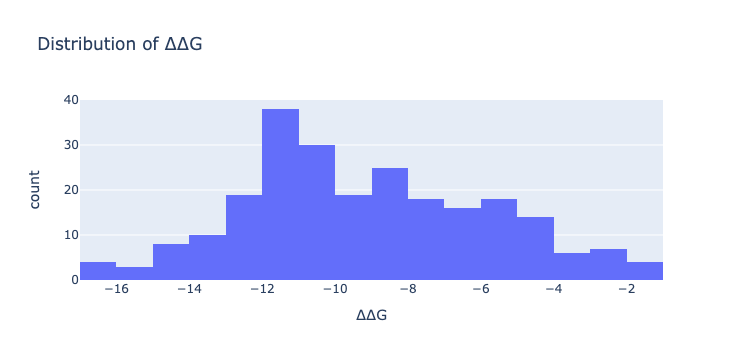

In [5]:
import plotly.express as px

px.histogram(combinations.loc[(combinations['∆∆G'] < 0) & (combinations.outcome == 'acceptable')], '∆∆G', title='Distribution of ∆∆G')

In [158]:
## Names are mucked up
import re
import numpy as np
from typing import Iterable

#first_atoms: Dict[str, Geometry.Point3D] = {name: hit.GetConformer().GetAtomPosition(0) for name, hit in hits.items()}
#mass_centres: Dict[str, Geometry.Point3D] = {name: np.sum(hit.GetConformer().GetPositions(), axis=0) / hit.GetNumAtoms() for name, hit in hits.items()}
coord_summed = {name: np.sum(hit.GetConformer().GetPositions()) for name, hit in hits.items()}

def get_name(mol, cutoff=0.001):
    #coords: Geometry.Point3D = mol.GetConformer().GetAtomPosition(0)
    csed = np.sum(mol.GetConformer().GetPositions())
    names = []
    for name, ref_csed in coord_summed.items():
        if np.abs(csed - ref_csed) <= cutoff:
            names.append(name)
    if len(names) == 1:
        return names[0]
    if len(set(re.findall('(x\d+)', ' '.join(names)))) == 1:
        # ['x0771L1AP1', 'x0771L0AP1']
        return names[0]
    if cutoff > 1:
        return 'LIG'
    if len(names) == 0:
        return get_name_by_first(mol, cutoff * 2)
    else:
        print(names)
        return get_name_by_first(mol, cutoff / 1.5)
    
def get_names(mols):
    if not isinstance(mols, Iterable):
        return []
    return [get_name(mol) if isinstance(mol, Chem.Mol) else 'LIG' for mol in mols]
        
            

combinations['regarded'] = combinations.hit_mols.apply(get_names)
combinations.to_pickle(f'fragmenstein-fragments.pkl.gz')
combinations.to_csv(f'fragmenstein-fragments.csv')

In [160]:
combinations['name'] = combinations['regarded'].apply('-'.join)

In [161]:
from rdkit import Chem, rdBase
from rdkit.Chem import AllChem
from molecular_rectifier import Rectifier

def to_simple_smiles(mol: Chem.Mol) -> str:
    if not isinstance(mol, Chem.Mol) or not mol.GetNumAtoms():
        return ''
    try:
        mol = AllChem.RemoveAllHs(mol)
        for atom in mol.GetAtoms():
            atom.SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
        return Chem.MolToSmiles(mol)
    except:
        return ''
    
with rdBase.BlockLogs():
    combinations['simple_smiles'] = combinations.unminimized_mol.apply(to_simple_smiles)

In [162]:
combinations.to_pickle(f'fragmenstein-fragments.pkl.gz')
combinations.to_csv(f'fragmenstein-fragments.csv')

In [ ]:
from smallworld_api import SmallWorld
from warnings import warn

sws = SmallWorld()

chemical_databases:pd.DataFrame = sws.retrieve_databases()

queries = combinations.loc[(combinations.outcome == 'acceptable')]['simple_smiles'].drop_duplicates().head(500)

similars = sws.search_many(queries.to_list(),
                           dist=25,
                           length=50,
                           db=sws.REAL_dataset,
                           tolerated_exceptions=Exception)
# query_index was added clientside to keep track!
similars['query_name'] = similars.query_index.map( queries.reset_index().name.to_dict() )
similars['hits'] = similars.query_index.map( queries.reset_index().hit_mols.to_dict() )
similars['name'] = similars['id'] + ':' + similars['query_name']
similars.to_pickle('similars-fragments.pkl.gz')
print(f'Found {len(similars)} analogues')

In [7]:
# similars = pd.read_pickle('similars-fragments.pkl.gz')
# print(f'Found {len(similars)} analogues')

Found 2953 analogues


In [176]:
# column 'index' in query is not similars.query_index, the index proper is:
queries = combinations.loc[(combinations.outcome == 'acceptable')].drop_duplicates('simple_smiles').head(500).reset_index()
# post error fix
for i, row in queries.iterrows():
    row.unminimized_mol.SetProp('_Name', row['name'])
    row.minimized_mol.SetProp('_Name', row['name'])
    for h, n in zip(row.hit_mols, row.regarded):
        # a bit incorrect as order is wrong
        h.SetProp('_Name', n)

similars['query_name'] = similars.query_index.map( queries['name'].to_dict() )
similars['real_hits'] = similars.query_index.map( queries.reset_index().hit_mols.to_dict() )
similars['hits'] = similars.query_index.apply(lambda i: [queries.loc[i].unminimized_mol] + queries.loc[i].hit_mols)
similars['name'] = similars['id'] + ':' + similars['query_name']
similars.to_pickle('similars-fragments.pkl.gz')
print(f'Found {len(similars)} analogues')

Found 2953 analogues


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, BRICS
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import pandera.typing as pdt
from typing import List, Dict
    
# ------------------------------------------------------
    
import logging
import pyrosetta_help as ph
import pyrosetta

ranking = '∆∆G' #@param ["LE", "∆∆G", "comRMSD"]
joining_cutoff:int = 10
quick_reananimation:bool = False
output_folder = 'frag_output'

import os
if not os.path.exists(output_folder):
    # isnt this done automatically?
    os.mkdir(output_folder)

import os, re
import pyrosetta, logging
import pandas as pd
from rdkit import Chem
from fragmenstein import Victor, Laboratory

Victor.work_path = output_folder
Victor.monster_throw_on_discard = False  # unmin + hits combo
Victor.monster_joining_cutoff = joining_cutoff  # Å
Victor.quick_reanimation = quick_reananimation  # for the impatient
Victor.error_to_catch = Exception  # stop the whole laboratory otherwise
#Victor.enable_stdout(logging.ERROR)
Victor.enable_logfile(os.path.join(output_folder, 'fragmenstein.log'), logging.ERROR)

from fragmenstein.laboratory.validator import place_input_validator

n_cores = 55

lab = Laboratory(pdbblock=pdbblock, covalent_resi=None)
placements:pd.DataFrame = lab.place(place_input_validator(similars), n_cores=n_cores)
placements.to_pickle(f'placed-fragments.pkl.gz')
placements.to_csv(f'placed-fragments.csv')

In [ ]:
placements.loc[placements.outcome == 'timeout'].index

In [ ]:
timeout_mask = (placements.outcome == 'timeout')

placements2: pd.DataFrame = lab.place(place_input_validator(similars.loc[timeout_mask]),
                                      n_cores=n_cores,
                                      timeout=600)

In [1]:
import plotly.express as px

px.histogram(placements.loc[(placements['∆∆G'] < 0) & (placements.outcome == 'acceptable')], '∆∆G', title='Distribution of ∆∆G')

NameError: name 'placements' is not defined

In [23]:
import functools

def fix_bad_cats(placements):
    placements['unminimized_mol'] = placements.unminimized_mol.fillna(Chem.Mol())
    placements['outcome'] = placements.apply(functools.partial(lab.categorize, size_tolerance=+50, move_cutoff=2.0), axis=1)

fix_bad_cats(placements)
placements.loc[(placements['∆∆G'] > -1) & (placements.outcome == 'acceptable'), 'outcome'] = 'weak'
placements.outcome.value_counts()

outcome
timeout       1531
acceptable    1372
weak            32
too moved       18
Name: count, dtype: int64

In [ ]:
import re, operator

def split_name(name):
    if not name:
        return ('','')
    if 'PV-' in name:
        match = re.match(r'(PV-\d+)-(.*)-(.*)', name).groups()
    else:
        match = re.match(r'(Z\d+)-(.*)-(.*)', name).groups()
    return (match[0], f"{match[1]}-{match[2]}" )

names = placements['name'].apply(split_name)

placements['enamine_name'] = names.apply(operator.itemgetter(0))
placements['merger_name'] = names.apply(operator.itemgetter(1))

# -----------------

n2mol = combinations.minimized_mol.to_dict()
# there seems to be some name bleaching? if so:
#n2mol = dict(zip([n.replace('_', '-') for n in n2mol.keys()], n2mol.values()))
placements['merger_mol'] = placements.merger_name.map(n2mol)

placements['hit_names'] = placements.merger_name.str.split('-')
placements['LE'] = placements.LE.abs()

placements.to_pickle(f'placed-fragments.pkl.gz')
placements.to_csv(f'placed-fragments.csv')

In [ ]:
from pathlib import Path

valids = placements.loc[placements.outcome == 'acceptable'].sort_values('∆∆G')
valids['combined_name'] = valids['name']
valids['name'] = valids['enamine_name']
valids['path'] = valids.combined_name.apply(lambda n: Path('frag_output') / n / f'{n}.holo_minimised.pdb')

valids.to_pickle('acceptables-fragments.pkl.gz')

valids.path.apply(Path.exists).value_counts()

In [ ]:
"""
https://github.com/matteoferla/PLIP-PyRosetta-hotspots-test/blob/main/plipspots_docking/plipspots/serial.py

This is a class I use to _apply_ PLIP to a pd.Series of molecules.
It is not built for the project, but works.
Note I have not dumped the methods that are not needed for the project.
"""

import os
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

from functools import singledispatchmethod
from typing import Tuple, Dict, List, Union
from collections import Counter, defaultdict
from plip.structure.preparation import PDBComplex, PLInteraction
from openbabel.pybel import Atom, Residue
from openbabel.pybel import ob
from fragmenstein.victor import MinimalPDBParser
import warnings


class SerialPLIPper:
    """
    Calling the instance will return a ``Dict[Tuple[str, str, int], int]``,
    where the key is interaction type, residue 3-letter name, residue index
    and the value is the count of interactions.
    Basically, applying Plip to a pd.Series of Chem.Mol.

    Unplacking it is kind of wierd, the best way I reckon is a brutal for-loop:

    .. code-block:: python

        import pandas as pd
        import pandera.typing as pdt

        intxndexes: pdt.Series[Dict[Tuple[str, str, int], int]] = hits.ROMol.apply(SerialPLIPper(pdb_filename))
        # columns will still be a tuple...:
        intxn_df = pd.DataFrame(intxndexes.to_list()).fillna(0).astype(int)
        hits['N_interactions'] = intxn_df.sum(axis='columns')
        for c in sorted(intxn_df.columns, key=lambda kv: kv[2]):
            # columns will be a colon-separated string:
            hits[':'.join(map(str, c))] = intxn_df[c]
    """

    def __init__(self, pdb_block: str, resn='LIG', chain='B'):
        assert 'ATOM' in pdb_block, f'No ATOM entry in block provided: {pdb_block}'
        self.pdb_block = pdb_block
        self.resn = resn
        self.chain = chain

    @classmethod
    def from_filename(cls, pdb_filename: str, *args, **kwargs):
        """
        The main constructor is from PDB block, this is from PDB file
        """
        with open(pdb_filename, 'r') as f:
            pdb_block = f.read()
        return cls(pdb_block, *args, **kwargs)

    def __call__(self, mol) -> Dict[Tuple[str, str, int], int]:
        if mol is None or not isinstance(mol, Chem.Mol) or mol.GetNumAtoms() == 0:
            return {}
        holo: str = self.plonk(mol)
        interaction_set: PLInteraction = self.get_interaction_set(holo)
        return self.get_interaction_counts(interaction_set)

    def assign_pdb(self, mol: Chem.Mol):
        """
        Fix the PDB info for the molecule, in place
        """
        counts = defaultdict(int)
        atom: Chem.Atom
        for atom in mol.GetAtoms():
            element: str = atom.GetSymbol()
            counts[element] += 1
            info = Chem.AtomPDBResidueInfo(atomName=f'{element: >2}{counts[element]: <2}',
                                           residueName=self.resn,
                                           residueNumber=1, chainId=self.chain)
            atom.SetPDBResidueInfo(info)

    def plonk(self, mol):
        """
        Temporarily here. Do not copy.
        There likely is a way to do this in OBabel
        This is using Fragmenstein ``MinimalPDBParser``.

        :param mol:
        :return:
        """
        pdbdata = MinimalPDBParser(self.pdb_block, remove_other_hetatms=True, ligname=self.resn)
        self.assign_pdb(mol)
        moldata = MinimalPDBParser(Chem.MolToPDBBlock(mol))
        pdbdata.append(moldata)
        return str(pdbdata)

    @singledispatchmethod
    def get_interaction_set(self) -> PLInteraction:
        """
        Overloaded method: block or mol return the iternaction set
        :return:
        """
        raise NotImplementedError

    @get_interaction_set.register
    def _(self, block: str) -> PLInteraction:
        holo = PDBComplex()
        holo.load_pdb(block, as_string=True)
        holo.analyze()
        return holo.interaction_sets[':'.join([self.resn, self.chain, str(1)])]

    @get_interaction_set.register
    def _(self, mol: Chem.Mol) -> PLInteraction:
        if mol.GetNumAtoms() == 0:
            raise ValueError('Molecule has no atoms')
        holo = PDBComplex()
        holo.load_pdb(self.plonk(mol), as_string=True)
        holo.analyze()
        return holo.interaction_sets[':'.join([self.resn, self.chain, str(1)])]

    def get_atomname(self, atom: Union[Atom, ob.OBAtom]) -> str:
        """
        Given an atom, return its name.
        """
        if isinstance(atom, Atom):
            res: ob.OBResidue = atom.residue.OBResidue
            obatom = atom.OBAtom
        elif isinstance(atom, ob.OBAtom):
            obatom: ob.OBAtom = atom
            res: ob.OBResidue = obatom.GetResidue()
        else:
            raise TypeError
        return res.GetAtomID(obatom)

    def get_atom_by_atomname(self, residue: Union[ob.OBResidue, Residue], atomname: str) -> ob.OBAtom:
        """
        Get an atom by its name in a residue.
        """
        if isinstance(residue, Residue):
            residue = residue.OBResidue
        obatom: ob.OBAtom
        for obatom in ob.OBResidueAtomIter(residue):
            if residue.GetAtomID(obatom).strip() == atomname:
                return obatom
        else:
            raise ValueError(f'No atom with name {atomname} in residue {residue.GetName()}')

    def get_interaction_counts(self, interaction_set: PLInteraction) -> Dict[Tuple[str, str, int], int]:
        """
        Count the number of interactions of each type for each residue
        """
        intxns: List = interaction_set.all_itypes
        intxn_dex = defaultdict(int)
        for intxn in intxns:
            key = (intxn.__class__.__name__, intxn.restype, intxn.resnr)
            intxn_dex[key] += 1
        return dict(sorted(intxn_dex.items(), key=lambda kv: kv[0][2]))

In [ ]:
chain_check = {l[21:26].strip() for l in valids.iloc[0].path.read_text().split('\n') if ' LIG ' in l} - {'LIG'}
print(chain_check)
chain = next(iter(chain_check)).split()[0]

import operator

plipper = SerialPLIPper('ATOM', resn='LIG', chain=chain)
def get_intxns(path: Path) -> dict:
    interaction_set: PLInteraction = plipper.get_interaction_set(path.read_text())
    return plipper.get_interaction_counts(interaction_set)

intxns = valids.path.apply(get_intxns)
key_order = sorted(set(intxns.apply(lambda d: list(d.keys())).sum()), key=operator.itemgetter(2))
for key in key_order:
    valids[key] = intxns.apply(lambda d: d.get(key, 0))
valids['N_interactions'] = valids[key_order].sum(axis=1)

valids.to_pickle('acceptables-fragments.pkl.gz')
valids[['name', 'regarded', 'smiles', '∆∆G', '∆G_bound', '∆G_unbound',
       'comRMSD', 'N_constrained_atoms', 'N_unconstrained_atoms', 'runtime',
       'LE',  'outcome',
       'percent_hybrid', 'N_interactions'] + key_order].to_csv('interactions.csv')
print('done')

In [ ]:
valids.to_pickle('acceptables-fragments.pkl.gz')
valids[['name', 'regarded', 'smiles', '∆∆G', '∆G_bound', '∆G_unbound',
       'comRMSD', 'N_constrained_atoms', 'N_unconstrained_atoms', 'runtime',
       'LE',  'outcome',
       'percent_hybrid', 'N_interactions'] + key_order].to_csv('interactions.csv')
print('done')

In [ ]:
from rdkit.Chem import PandasTools

short = combinations.loc[(combinations.outcome == 'acceptable')].sort_values('∆∆G').reset_index().drop_duplicates('name')

PandasTools.WriteSDF(df=short,
                    out=f'combinations-fragments.sdf',
                    molColName='minimized_mol',
                    idName='name',
                    properties=['regarded', 'smiles', '∆∆G', '∆G_bound', '∆G_unbound',
       'comRMSD', 'N_constrained_atoms', 'N_unconstrained_atoms', 'runtime',
       'LE',  'outcome',
       'percent_hybrid']
                    )

short[['name', 'regarded', 'smiles', '∆∆G', '∆G_bound', '∆G_unbound',
       'comRMSD', 'N_constrained_atoms', 'N_unconstrained_atoms', 'runtime',
       'LE',  'outcome',
       'percent_hybrid']].to_csv(f'combinations-fragments.csv')

In [ ]:
from rdkit.Chem import PandasTools

placements['regarded'] = placements.merger_name.str.split('-')
short = placements.loc[(placements.outcome == 'acceptable')].sort_values('∆∆G').drop_duplicates('name')

PandasTools.WriteSDF(df=short,
                    out=f'placements-fragments.sdf',
                    molColName='minimized_mol',
                    idName='name',
                    properties=['regarded', 'merger_name', 'smiles', '∆∆G', '∆G_bound', '∆G_unbound',
       'comRMSD', 'N_constrained_atoms', 'N_unconstrained_atoms', 'runtime',
       'LE',  'outcome',
       'percent_hybrid']
                    )

short[['name', 'regarded', 'smiles', '∆∆G', '∆G_bound', '∆G_unbound',
       'comRMSD', 'N_constrained_atoms', 'N_unconstrained_atoms', 'runtime',
       'LE',  'outcome',
       'percent_hybrid']].to_csv(f'placements-fragments.csv')

In [34]:
valids.merger_name

1415          AG7P11S33-G83P1S78
794            E22P1S38-E22P1S10
1375          AG7P11S28-AG7P8S10
633             E22P1S19-E22P1S7
1412          AG7P11S33-G83P1S78
                  ...           
517           G83P1S173-E22P1S32
1786           AG7P12S22-AG7P8S5
607             E22P1S19-E22P1S7
2915    x1604hydroxyl-x0771benzo
825          E22P1S39-x1498L1BP1
Name: merger_name, Length: 1372, dtype: object

In [35]:
valids['merger_mol'] = valids.merger_name.map(placements.set_index('merger_name').minimized_mol.to_dict().get)

In [37]:
valids = valids.loc[~valids.merger_mol.isna()]

In [38]:
valids

,name,smiles,error,mode,∆∆G,∆G_bound,∆G_unbound,comRMSD,N_constrained_atoms,N_unconstrained_atoms,...,"(hbond, HIS, 161)","(hbond, VAL, 162)","(hbond, GLY, 163)","(halogenbond, GLY, 164)","(hbond, GLY, 164)","(hydroph_interaction, ASN, 165)","(hbond, GLY, 166)","(hydroph_interaction, PHE, 170)","(pistack, PHE, 170)",N_interactions
1415,Z4145520382,CCC(C)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)NC(C)C...,,expansion,-11.431698,-9.554016,1.877682,1.154675,54.0,0.0,...,0,1,0,0,1,0,0,0,0,6
794,Z4032625002,C[C@H](O)[C@H](C)NC(=O)C(NC(=O)OCC1=CC=CC=C1)C...,,expansion,-10.888881,-8.614142,2.274739,0.970319,45.0,0.0,...,0,1,0,0,1,0,0,0,0,6
1375,Z4147217663,CCOC(=O)[C@@H](C)N(C)C(=O)[C@H](CC1=CC=C(O)C=C...,,expansion,-10.795120,-9.083111,1.712009,0.938484,50.0,0.0,...,0,0,0,0,1,0,0,0,0,6
633,Z5144784941,O=C(NC(CC1=CC=CC=C1)C(=O)N[C@H](CC2=CC=CC=C2)C...,,expansion,-10.300371,-6.714211,3.586160,1.000237,53.0,0.0,...,0,1,0,0,0,0,0,0,0,6
1412,Z4076099163,CC(C)CC(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)NC(C)C...,,expansion,-10.174137,-9.057158,1.116979,1.059362,54.0,0.0,...,0,1,0,0,1,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,PV-004309111368,C[C@@H](NC(=O)CC(=O)O)C(N)=O,,expansion,-1.179669,-0.737794,0.441875,0.751833,20.0,0.0,...,0,0,0,0,1,0,0,0,0,1
1786,PV-004002543346,CC(C)CC(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N2[C@@...,,expansion,-1.060797,0.436289,1.497086,1.141235,39.0,5.0,...,0,0,0,0,1,0,0,0,0,6
607,Z1767819991,O=C(C1CC2=CC=CC=C2N1C(=O)OCC3=CC=CC=C3)N4CCCC5...,,expansion,-1.049347,1.613359,2.662706,1.555478,41.0,6.0,...,0,0,0,0,1,0,0,0,0,5
2915,Z4238192148,CCCCS[C@@H]1CCC[C@H](O)C1,,expansion,-1.047392,-0.924728,0.122664,1.291434,30.0,0.0,...,0,0,0,0,0,0,1,0,0,3


In [ ]:
def unbleach(names: list, fluff_marker = '§'):
    return [f'{names[0]}_{names[1]}{fluff_marker}{names[2]}',
            f'{names[3]}_{names[4]}{fluff_marker}{names[5]}',
           ]
valids['hit_names'] = valids.hit_names.apply(unbleach)

In [ ]:
## Names are mucked up
import re
import numpy as np
from typing import Iterable

#first_atoms: Dict[str, Geometry.Point3D] = {name: hit.GetConformer().GetAtomPosition(0) for name, hit in hits.items()}
#mass_centres: Dict[str, Geometry.Point3D] = {name: np.sum(hit.GetConformer().GetPositions(), axis=0) / hit.GetNumAtoms() for name, hit in hits.items()}
coord_summed = {name: np.sum(hit.GetConformer().GetPositions()) for name, hit in hits.items()}

def get_name(mol, cutoff=0.001):
    #coords: Geometry.Point3D = mol.GetConformer().GetAtomPosition(0)
    csed = np.sum(mol.GetConformer().GetPositions())
    names = []
    for name, ref_csed in coord_summed.items():
        if np.abs(csed - ref_csed) <= cutoff:
            names.append(name)
    if len(names) == 1:
        return names[0]
    if len(set(re.findall('(x\d+)', ' '.join(names)))) == 1:
        # ['x0771L1AP1', 'x0771L0AP1']
        return names[0]
    if cutoff > 1:
        return 'LIG'
    if len(names) == 0:
        return get_name_by_first(mol, cutoff * 2)
    else:
        print(names)
        return get_name_by_first(mol, cutoff / 1.5)
    
def get_names(mols):
    if not isinstance(mols, Iterable):
        return []
    return [get_name(mol) if isinstance(mol, Chem.Mol) else 'LIG' for mol in mols]
        
            

valids['hit_names'] = valids.hit_mols.apply(get_names)

In [40]:
from michelanglo_api import MikeAPI
from rdkit import Chem
from typing import List
import pandas as pd
import json

# declare variables
hit_names = list(hits.keys())
!mkdir -p upload
!cp filtered_hits.sdf upload/EV-D68_hits3.sdf
hit_filename = 'EV-D68_hits3.sdf'

headers = ['name', 'hits', 'RMSD', '∆∆G', 'LE', 'N unconstrained atoms', 'N constrained atoms', 'N interactions']
metadata: pd.DataFrame = valids.loc[~valids.merger_mol.isna()]\
                               .rename(columns=dict(hit_names='hits', comRMSD='RMSD',
                                                    dist='distance',
                                                    N_constrained_atoms='N constrained atoms',
                                                    N_unconstrained_atoms='N unconstrained atoms',
                                                    N_interactions='N interactions'))[headers]
metadata_filename: str = 'EV-D68_metadata3.json'

for k in ('∆∆G', 'LE', 'RMSD'):
    metadata[k] = metadata[k].fillna(999).astype(float).round(1)
for k in ('N unconstrained atoms',):
    metadata[k] = metadata[k].fillna(-1).astype(int)
metadata = metadata.copy()


base_url = 'https://www.stats.ox.ac.uk/~ferla/mols/'  # base url path
uuid = '63cf4578-a32d-44ca-86aa-c6c0eded48c2' # uuid of the page target

combo_filename = 'EV-D68_combinations3.sdf'
with Chem.SDWriter('upload/'+ combo_filename) as sdw:
    combo_names = []
    for i, row in valids.iterrows():
        if not isinstance(row.merger_mol, Chem.Mol):
            continue
        row.merger_mol.SetProp('_Name', row.merger_name)
        if row.merger_mol.GetNumAtoms() == 0:
            continue
        sdw.write(row.merger_mol)
        # odd way but hey:
        combo_names.append(row['name'])

placement_filename = 'EV-D68_placements3.sdf'
with Chem.SDWriter('upload/'+ placement_filename) as sdw:
    placement_names = []
    for i, row in valids.iterrows():
        if not isinstance(row.minimized_mol, Chem.Mol):
            continue
        row.minimized_mol.SetProp('_Name', row['name'])
        if row.minimized_mol.GetNumAtoms() == 0:
            continue
        sdw.write(row.minimized_mol)
        placement_names.append(row['name'])
        
with open('upload/'+ metadata_filename, 'w') as fh:
    json.dump(dict(
                   headers=headers,
                   data=metadata.values.tolist(),
                   modelnamedex={'combination': combo_names,
                                 'placement': placement_names,
                                },
                   hitnames=hit_names,
            ), fh)
    
# make a page

mike = MikeAPI()
page = mike.get_page(uuid)

page.loadfun = page.get_fragment_js(hit_sdf_url=base_url+hit_filename,
                               model_sdf_urldex={'combination': base_url+combo_filename,
                                                 'placement' : base_url+placement_filename,
                                                },
                               metadata_url=base_url+metadata_filename,
                               model_colordex={'combination': 'salmon',
                                               'placement': 'cyan'},
                               hit_color='grey',
                               template_color='gainsboro',
                               name_col_idx = headers.index('name'),
                               hit_col_idx = headers.index('hits'),
                               target_col_idx = -1, # headers.index('target')
                               sort_col = headers.index('N interactions'),
                               sort_dir = 'desc',
                               fun_name ='loadTable')

# create a way to load the protein
# laziest: 
#page.loadfun += 'setTimeout(loadTable, 1000)'
# better:
page.loadfun += """
window.loadprotein = (prot) => {prot.removeAllRepresentations(); 
                                prot.addRepresentation('cartoon');
                                prot.addRepresentation('line');
                                prot.autoView(); 
                                prot.setName('template');
                                loadTable(); 
                                }
"""
page.loadfun = page.loadfun.replace('"model_colordex": {"combination": "teal", "placement": "teal"}',
                                    '"model_colordex": {"combination": "salmon", "placement": "turquoise"}'
                                   )
page.proteins[0]['loadFx'] = 'loadprotein'
page.title = 'EV-D68 3C protease followups (Fragmenstein decomposed)'
page.description = f'## Predicted followups\nCombinations in salmon and their purchasable analogue from Enamine Real in turquoise.\n\n Data in table is for make-on-demand analogues. Protein is constant for the sake of memory, but induced fit may have repacked the protein in specific case hence the odd case of calculated nice score and visual clashes.\n\nRMSD cutoff loosened to 2Å'
page.columns_text = 6
page.commit()
print('Done')

Done


In [2]:
# post crash
import pandas as pd

similars = pd.read_pickle('similars-fragments.pkl.gz')

In [11]:
similars['real_hits'].iloc[0][1]

{}

In [15]:
## Names are mucked up
import re
import numpy as np
from typing import Iterable

#first_atoms: Dict[str, Geometry.Point3D] = {name: hit.GetConformer().GetAtomPosition(0) for name, hit in hits.items()}
#mass_centres: Dict[str, Geometry.Point3D] = {name: np.sum(hit.GetConformer().GetPositions(), axis=0) / hit.GetNumAtoms() for name, hit in hits.items()}
coord_summed = {name: np.sum(hit.GetConformer().GetPositions()) for name, hit in hits.items()}

def get_name(mol, cutoff=0.001):
    #coords: Geometry.Point3D = mol.GetConformer().GetAtomPosition(0)
    csed = np.sum(mol.GetConformer().GetPositions())
    names = []
    for name, ref_csed in coord_summed.items():
        if np.abs(csed - ref_csed) <= cutoff:
            names.append(name)
    if len(names) == 1:
        return names[0]
    if len(set(re.findall('(x\d+)', ' '.join(names)))) == 1:
        # ['x0771L1AP1', 'x0771L0AP1']
        return names[0]
    if cutoff > 1:
        return 'LIG'
    if len(names) == 0:
        return get_name_by_first(mol, cutoff * 2)
    else:
        print(names)
        return get_name_by_first(mol, cutoff / 1.5)
    
def get_names(mols):
    if not isinstance(mols, Iterable):
        return []
    return [get_name(mol) if isinstance(mol, Chem.Mol) else 'LIG' for mol in mols]

similars['hit_names'] = similars['real_hits'].apply(get_names)

In [22]:
similars.loc[similars['name'].str.contains(':x') & similars['name'].str.contains('-x')].hit_names.apply('-'.join).value_counts()

hit_names
x0771benzo-x1604base        50
x1604hydroxyl-x0771benzo    50
Name: count, dtype: int64